# Project: Recommender System

Objective: implement a recommender system based on user-item data, with linear algebra techniques.

## The MovieLens database

GroupLeng.org proposes several movie rating dataset by users of the movie recommendation website movielens.org.
The dataset you will use is the MovielLens 100K Dataset. It is a stable benchmark that can be used for research and development. It contains 100 000 ratings on 1700 movies from around 1000 users. In addition to the ratings, metadata are available for users (age, sexe, occupation) and movies (title, release date, genre, IMDb link).

The file `u.data` contains all the ratings. The first 5 rows are

```
196	 242	3   881250949
186	 302	3   891717742
22      377    1   878887116
244      51    2   880606923
166	 346	1   886397596
```

The data are organized by columns (user_id, movie_id, rating, date). Metadata for users are in the file` u.user` and metadata for movies are in `u.item`. User IDs range from 1 to `m` and item IDs range from 1 to `n`. 

Files `u1.base` and `u1.test` are subsets of the file `u.data`: a base file containing 80% of the data and a test file containing the remaining 20% of the data. Files `u2.*`, `u3.*`, `u4.*`, `u5.*` are similar; each test file contains a different 20% subset fo the data. 

### Question 1 - Load the data into python

First download the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) and unzip it in your project directory. As the name suggests, read the `README` file.

You will need the following python packages

In [1]:
import csv
import numpy as np
import matplotlib as plt
import pylab as pl

If you are using a python notebook, add the following command to have plots displayed inline

In [2]:
%matplotlib inline 
#number of users
nu=943
#number of items
ni=1682

Import the following files from the MovieLens 100K dataset: `u1.base`, `u1.test`, `u.user`, `u.item`
You can use the following codes to import the datasets

In [3]:
baseFileName = 'u1.base' # training dataset
testFileName = 'u1.test' # test dataset (complement of the test dataset)
userFileName = 'u.user'
itemFileName = 'u.item'

with open(baseFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(testFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    testUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['user','age','sex','occupation','zipcode'])
    User = [dict([key, value] for key, value in row.items()) for row in list(reader)] 
with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['movie', 'movie title', 'release date', 'video release date',\
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',\
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
              'Thriller', 'War', 'Western'])
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]    

If you have decoding problems, try saving the datafiles in UTF-8 and set the encoding option of the `open` function to 'utf-8'.

## Recommendation problems

Recommendation problems of two types. 

- For a given user and a given movie, give a rating prediction
- For a given user, provide a list of N movie recommendations 

Several approaches are used to answer these problems. Content-based methods try to associate item characteristics to the aims of the users. These methods need to have access to a large amount of information on items and one must be able to know the aims of the users. Another class of methods, Collaborative Filtering (CF), works by comparing preferences of others users to construct the recommendations. In contrast to content-based methods, the nature of the items play no role whatsoever in CF methods. Only the ratings given by users are used to evaluate the relelance or the items. The limitation of CF methods is that they require users to rate several items before recommendations start becoming relevant. Thus, for a recommender system using CF methods, a new user poses a 'cold start' problem, and this is why new users are often asked to rate a few random items.  

CF methods are based on a user-item matrix `R` of size m x n, where each coefficient $R_{u,i}$ is the rating from user $u$ on item $i$. A default value of 0 can be set when there is no rating. The prediction task consists in providing a prediction $p_{u,i}$ for unknown user-item pairs. The recommendantion task consists in providing a list of N items to a given user.

**1.2.1 Question 2 - User-item matrix**

**Q2.1** From the user-item data imported from `u1.base`, create a matrix `R` with coefficient `R[u-1,i-1]` being the rating given by user `u` for item `i` (`python` has a zero-based index, while IDs start at 1). If no rating is available, the coefficient must be set to 0. 

In [4]:
# Fill the user-item matrix
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items
ratingPerUser = np.zeros( (nu,1) )
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']

**Q2.2** Check that the matrix `R` has the size m x n, where m is the total number of users, and n is the total number of items that can be found in the file `u.data`. This is important because it is possible that not all user or items are part of the base dataset. Missing users or items still need to be included in the matrix `R` for correct row and column indexing. 

To fill up the matrix `R` you can use the following code.

In [5]:
R.shape

(943, 1682)

In [6]:
R

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

The matrix `R` is _sparse_, most of its coefficients are zero. For the recommendation method to work, we will need first to remove the sparsity. Two obvious ways to remove the zeros in `R`

- row averaging: for each row, compute the average non-zero ratings, and replace each zero by this average. 
- column averaging: for each column, compute the average non-zero ratings, and replace each zero by this average.

**Q2.3** Compute both row-averaged `Rr` and column averaged `Rc` matrices. Make sure that if a row or a column is empty (all zeros), the row or the columns remains zero.

You can visualize the matrices with the command

Row averaging and column averaging : 

In [7]:
Rr = np.zeros((nu,ni))
for i in range(nu):
    summ = 0
    effective = 0
    for j in range(ni):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rr[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for j in range(ni):
        if Rr[i][j]==0:
            Rr[i][j]=average
Rc = np.zeros((nu,ni))
for j in range(ni):
    summ = 0
    effective = 0
    for i in range(nu):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rc[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for i in range(nu):
        if Rc[i][j]==0:
            Rc[i][j]=average

In [8]:
Rr

array([[5.        , 3.        , 4.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [4.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [5.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 5.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [9]:
Rc

array([[5.        , 3.        , 4.        , ..., 2.        , 3.        ,
        3.        ],
       [4.        , 3.18095238, 3.        , ..., 2.        , 3.        ,
        3.        ],
       [3.89295039, 3.18095238, 3.        , ..., 2.        , 3.        ,
        3.        ],
       ...,
       [5.        , 3.18095238, 3.        , ..., 2.        , 3.        ,
        3.        ],
       [3.89295039, 3.18095238, 3.        , ..., 2.        , 3.        ,
        3.        ],
       [3.89295039, 5.        , 3.        , ..., 2.        , 3.        ,
        3.        ]])

visualization of the Rr matrix

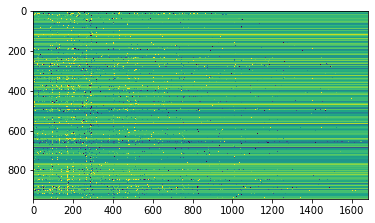

In [10]:
pl.imshow(Rr, interpolation='none')

visualization of the Rc matrix

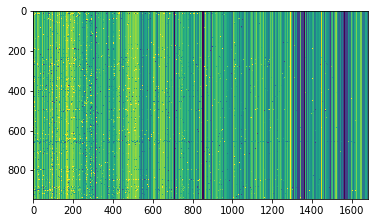

In [11]:
pl.imshow(Rc, interpolation='none')

## Low-rank approximation using the SVD

### Question 3 - Low-rank approximation

**Q3.1** Compute the reduced singular value decomposition of the matrix `Rc` (the column-averaged matrix) to obtain `U`, `s`, `Vs` such that `Rc = U diag(s) Vs`.  

For a given positive integer `k`, one can define a rank `k` matrix 

$$R_k = U_k S_k V_k^*,$$

where $U_k, S_k$, and $V_k^*$ are matrices defined based on the SVD of `Rc`.
This matrix `Rk` could be used to make a user-item prediction. However, to make predictions computationally efficient, it is not necessary to compute the complete matrix `Rk`. Indeed, the matrix `Rk` is best represented by its SVD: the matrices `Uk`, `Sk` and `Vk` are more compact, and predicitons can be computed on demand by using the formula

$$p[u,i] = U_k[u,:] \sqrt{S_k} \sqrt{S_k} V_k^*[:,i],$$

which is just a sort of scalar product between row `u` of `Uk` and column `i` of `Vk` weighed by the singular values. To simplify the notation even more, we can define two **feature matrices** `X`, `Y`,

- $X = U_k \sqrt{S_k},$
- $Y = \sqrt{S_k} V_k^*.$

Then the prediction for user `u` and item `i` is the scalar product of row `u` of `X` by column `i` of `Y`. 

**Q3.2** Write a routine called `feature_matrices` that takes as input the rank `k` and the SVD output `U`, `s` and `Vs`, and returns the two user feature matrix `X` and the item feature `Y`. (Do not compute an SVD within this routine).

The square root of a matrix is not defined in general, but for diagonal matrices, the square root of a matrix is just the matrix of the sqaure roots of the diagonals. 

**Q3.3** Can you give an interpretation of the feature matrices `X` and `Y`? Try with `k=1..3`.

In [12]:
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)
S=np.diag(s)
C=U.dot(S).dot(Vs)

In [13]:
def feature_matrices(k,U,S,Vs):
    Uk=U[:,:k] #to keep the first k columns
    Vsk=Vs[:k,:] #to keep the first k lines
    Sk=np.diag(s[:k])
    X=Uk.dot(np.sqrt(Sk))
    Y=np.sqrt(Sk).dot(Vsk)
    return X, Y

In [14]:
def predictionSVD(U,S,Vh,k):
    Uk=U[:,:k] #to keep the first k columns
    Vsk=Vs[:k,:] #to keep the first k lines
    Sk=np.diag(s[:k])
    X=Uk.dot(np.sqrt(Sk))
    Y=np.sqrt(Sk).dot(Vsk)
    return Xk.dot(Yk)

In [15]:
feature_matrices(1,U,S,Vs)
feature_matrices(2, U, S, Vs)
feature_matrices(3, U, S, Vs)

(array([[-2.06400667e+00, -2.42074803e-02,  6.84571959e-02],
        [-2.05788420e+00,  1.29679650e-02, -3.96362242e-04],
        [-2.05127909e+00,  6.89364220e-02,  2.01662979e-02],
        ...,
        [-2.05849807e+00, -5.72910556e-02, -2.53235565e-02],
        [-2.07254956e+00, -2.00394871e-01,  4.03576602e-02],
        [-2.05427971e+00, -4.61491858e-03, -1.75554120e-02]]),
 array([[-1.89534741, -1.54851958, -1.46017573, ..., -0.97324883,
         -1.45987325, -1.45987325],
        [-0.83513453, -0.33624919, -0.19057922, ...,  0.05525668,
          0.08288502,  0.08288502],
        [ 0.06354871,  0.40781084, -0.04599214, ..., -0.057633  ,
         -0.0864495 , -0.0864495 ]]))

The matrix Rk can be used to make a prediction of the user item. 𝑋𝑘 and 𝑌𝑘 are the feature matrices, of users and items (movies) respectively (vertical for X, horizontal for Y). The vectors 𝑋𝑘(𝑢) correspond for each user u, to their evaluation preferences based on the first k evaluations. The vectors 𝑌𝑘(𝑖) correspond for each movie i to its characterization according to the first k general trends. A trend can correspond to a similarity between groups. Sk seeks to scale the values

(traduction française : La matrice Rk peut être utilisée pour faire une prédiction de l'élément utilisateur. 𝑋𝑘 et 𝑌𝑘 sont les matrices features, respectivement des utilisateurs et des items (films) (verticale pour X, horizontal pour Y). Les vecteurs 𝑋𝑘(𝑢) correspondent pour chaque utilisateur u, à ses préférences d'évaluation en fonction des k premières évaluation. Les vecteurs 𝑌𝑘(𝑖) correspondent pour chaque film i à sa caractérisation selon les k premières tendances générales. Une tendance peut correspondre a une similitude entre les groupes. Sk cherche a mettre a l'echelle les valeurs)

## Quality of the prediction

The feature matrices were constructed from the base dataset only. We will evaluate the quality of the prediction by comparing the prediciton to the real ratings from the test dataset. For each user-item pair in the test dataset, we will compute a prediction. The measure of the quality of the prediciton is the **mean absolute error** (MAE) 

$$MAE = \frac{1}{N_{test}} \sum_{r \in \text{test set}} |p_{u(r),i(r)} - trueRating(r)|.$$

### Question 4 - Mean absolute error 

**Q4.1** For `k = 1, 2, ..., 30, 40, 50`, compute the MAE based on the rank `k` approximation. Use the following code to do that. 


k =  1 MAE =  0.817535874429764
k =  2 MAE =  0.8060182179584896
k =  3 MAE =  0.8063794520622469
k =  4 MAE =  0.7999480561568809
k =  5 MAE =  0.7971481283460092
k =  6 MAE =  0.7954078602944552
k =  7 MAE =  0.79424542002051
k =  8 MAE =  0.7934606960033898
k =  9 MAE =  0.7929599209815952
k =  10 MAE =  0.792119391684589
k =  11 MAE =  0.7915582897424817
k =  12 MAE =  0.7917961109046985
k =  13 MAE =  0.7915966687892533
k =  14 MAE =  0.7914601392655753
k =  15 MAE =  0.7913051066122982
k =  16 MAE =  0.7915865673732649
k =  17 MAE =  0.791788903310373
k =  18 MAE =  0.7920935093368853
k =  19 MAE =  0.792137673127241
k =  20 MAE =  0.7918432282624869
k =  21 MAE =  0.7922044504481306
k =  22 MAE =  0.7923580951397499
k =  23 MAE =  0.7930691463044667
k =  24 MAE =  0.7931834367872042
k =  25 MAE =  0.7935053356299926
k =  26 MAE =  0.7941679735684652
k =  27 MAE =  0.7949481438277141
k =  28 MAE =  0.7950292409544367
k =  29 MAE =  0.7950363212450078
k =  30 MAE =  0.795321275505

Text(0, 0.5, 'MAE')

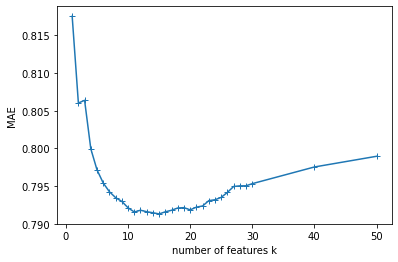

In [16]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
for k in range_k:
    # compute the truncated SVD

    X, Y = feature_matrices(k, U, s, Vs) 
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
    print("k = ",k, "MAE = ",(np.mean(np.abs(errorRating))) )
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

**Q4.2** Is there an optimal number of features `k`? How much improvement in MAE is there compared to the naive prediction based on the column-averaged matrix?

Yes there is an optimal number: k = 15 because it is the minimum of the curve, where the MAE is minimal. There is an improvement of the MAE when we make with the matrix Rr because k=15 whereas for the matrix Rc we find k = 17
(traduction française: Oui il existe un nombre optimal : k = 15 car il s'agit du minimun de la courbe, la ou le MAE est minimun. Il y a une amélioration du MAE quand on fait avec la matrice Rr car k=15 alors que pour la matrice Rc on trouve k = 17)

### Calcul de la MAE Naïve avec Rr:

k =  1 MAE =  0.8326768692021637
k =  2 MAE =  0.821106444412233
k =  3 MAE =  0.8120213134397164
k =  4 MAE =  0.8111105452391708
k =  5 MAE =  0.8087415447159844
k =  6 MAE =  0.8081383533467974
k =  7 MAE =  0.8061760029475262
k =  8 MAE =  0.8051129430430006
k =  9 MAE =  0.8052048904261166
k =  10 MAE =  0.805252035562353
k =  11 MAE =  0.8056244360281724
k =  12 MAE =  0.8051726712361056
k =  13 MAE =  0.8050435806418506
k =  14 MAE =  0.8050184584915522
k =  15 MAE =  0.8049808085027961
k =  16 MAE =  0.8052217080662871
k =  17 MAE =  0.804927151551959
k =  18 MAE =  0.8049848542235899
k =  19 MAE =  0.8052379530650747
k =  20 MAE =  0.8058841067621308
k =  21 MAE =  0.8059360396931372
k =  22 MAE =  0.8065537789859755
k =  23 MAE =  0.8069833734921463
k =  24 MAE =  0.807133613174707
k =  25 MAE =  0.8071045037449872
k =  26 MAE =  0.8072346777592163
k =  27 MAE =  0.8075462931284447
k =  28 MAE =  0.807962210835326
k =  29 MAE =  0.8084340476287376
k =  30 MAE =  0.80857604256

Text(0, 0.5, 'MAE')

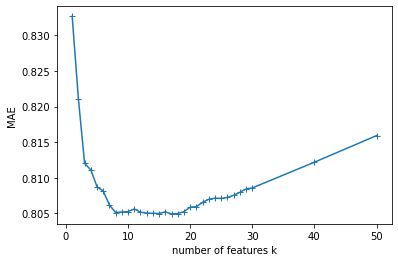

In [17]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)
for k in range_k:
    # compute the truncated SVD

    X, Y = feature_matrices(k, U, s, Vs) 
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
    print("k = ",k, "MAE = ",(np.mean(np.abs(errorRating))) )
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [18]:
print("MAE Naive avec Rr", np.mean(MAE))

MAE Naive avec Rr 0.8084128405882716


### Calcul de la MAE Naïve avec Rc:

k =  1 MAE =  0.817535874429764
k =  2 MAE =  0.8060182179584896
k =  3 MAE =  0.8063794520622469
k =  4 MAE =  0.7999480561568809
k =  5 MAE =  0.7971481283460092
k =  6 MAE =  0.7954078602944552
k =  7 MAE =  0.79424542002051
k =  8 MAE =  0.7934606960033898
k =  9 MAE =  0.7929599209815952
k =  10 MAE =  0.792119391684589
k =  11 MAE =  0.7915582897424817
k =  12 MAE =  0.7917961109046985
k =  13 MAE =  0.7915966687892533
k =  14 MAE =  0.7914601392655753
k =  15 MAE =  0.7913051066122982
k =  16 MAE =  0.7915865673732649
k =  17 MAE =  0.791788903310373
k =  18 MAE =  0.7920935093368853
k =  19 MAE =  0.792137673127241
k =  20 MAE =  0.7918432282624869
k =  21 MAE =  0.7922044504481306
k =  22 MAE =  0.7923580951397499
k =  23 MAE =  0.7930691463044667
k =  24 MAE =  0.7931834367872042
k =  25 MAE =  0.7935053356299926
k =  26 MAE =  0.7941679735684652
k =  27 MAE =  0.7949481438277141
k =  28 MAE =  0.7950292409544367
k =  29 MAE =  0.7950363212450078
k =  30 MAE =  0.795321275505

Text(0, 0.5, 'MAE')

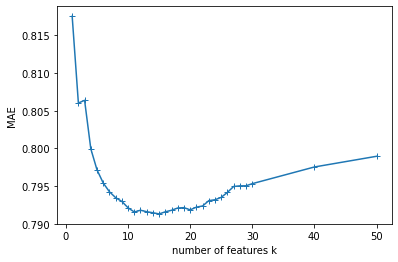

In [19]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)
for k in range_k:
    # compute the truncated SVD
    X, Y = feature_matrices(k, U, s, Vs)
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
    print("k = ",k, "MAE = ",(np.mean(np.abs(errorRating))) )
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [20]:
print("MAE Naive avec Rc", np.mean(MAE))

MAE Naive avec Rc 0.7952405929975865


**Q4.3** For `k = 1, 2, ..., 30, 40, 50`, compute the MAE based on the rank `k` approximation of the row-averaged matrix `Rr`. Compared with the results obtained with the column-averaged matrix `Rc`. What kind of matrix completion works best?

The type of matrix completion that works best is the Rc matrix because it has a lower MAE  (traduction française :Le type de complétion de matrice qui fonctionne le mieux est la matrice Rc car elle a une MAE plus faible)

### Question 5 - Repeat question 4 for the other training datasets

For the recommender system to be robust, the results obtained in Question 4 (optimal value of `k`, row-averaged matrix vs column-averaged matrix) should not depend on the training dataset. Repeat the question 4 with the other training datasets `u2`, `u3`, `u4` and `u5`. 

**Q5.1** Are your results robust? Answer quantitatively.

yes they are solid because when we substrat the minimal MAE from the row average from the minimal MAE from the column average, we get the following values :

u1: 0.8084-0.7952 = 0.0132

u2: 0.7908-0.7824 = 0.0084

u3: 0.7807-0.7769 = 0.0038

u4: 0.7860-0.7760 = 0.0100

u5: 0.7941-0.7864 = 0.0077

We can see that u1 has the highest MAE for the two averaged matrices, but all values are pretty close from one another.
The values for the column and row are small enough to consider the system robust.




**Q5.2** How would you change the recommender system? 

I would modify the system of recommendation so that as soon as we reach more than 20 films note it removes the first notes given. We could make an SVD++ which is more efficient than our SVD. One difference for example is that the chance of the user "liking" an item that he has evaluated is higher than for a random un-evaluated item. Or we could use the restricted Boltzmann machine which is a type of artificial neural network.

(traduction française : Je modifierais le systeme de recommandation pour que des que si l'on atteind plus de 20 films noté, cela supprime les premeriere notes donné. On pourrait faire une SVD++ qui est plus performante que notre SVD. Une difference par exemple est que la chance que l'utilisateur "aime" un élément qu'il a évalué sont plus élevées que pour un élément aléatoire non évalué. Ou l'on pourrait utiliser la machine de Boltzmann restreinte qui est un type de réseau de neurones artificiels)

For U2

In [21]:
baseFileName = 'u2.base' # training dataset
testFileName = 'u2.test' # test dataset (complement of the test dataset)
userFileName = 'u.user'
itemFileName = 'u.item'

with open(baseFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(testFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    testUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['user','age','sex','occupation','zipcode'])
    User = [dict([key, value] for key, value in row.items()) for row in list(reader)] 
with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['movie', 'movie title', 'release date', 'video release date',\
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',\
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
              'Thriller', 'War', 'Western'])
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]    

In [22]:
# Fill the user-item matrix
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items
ratingPerUser = np.zeros( (nu,1) )
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']

In [23]:
Rr = np.zeros((nu,ni))
for i in range(nu):
    summ = 0
    effective = 0
    for j in range(ni):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rr[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for j in range(ni):
        if Rr[i][j]==0:
            Rr[i][j]=average
Rc = np.zeros((nu,ni))
for j in range(ni):
    summ = 0
    effective = 0
    for i in range(nu):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rc[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for i in range(nu):
        if Rc[i][j]==0:
            Rc[i][j]=average

In [24]:
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)

Text(0, 0.5, 'MAE')

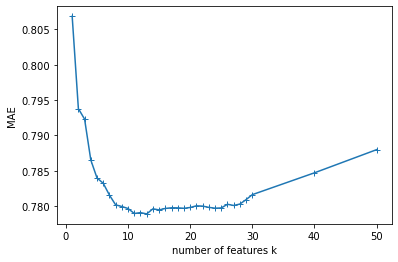

In [25]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
for k in range_k:
    # compute the truncated SVD
    X, Y = feature_matrices(k, U, S, Vs)
   
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [26]:
print("MAE Naive avec Rc", np.mean(MAE))

MAE Naive avec Rc 0.782437070834483


In [27]:
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)

Text(0, 0.5, 'MAE')

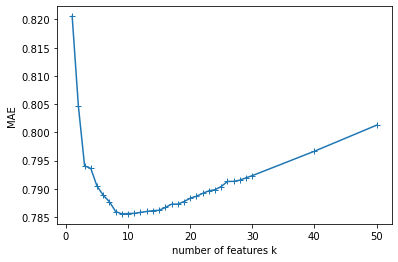

In [28]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
for k in range_k:
    # compute the truncated SVD

    X, Y = feature_matrices(k, U, s, Vs) 
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [29]:
print("MAE Naive avec Rr", np.mean(MAE))

MAE Naive avec Rr 0.7908947540265239


For U3

In [30]:
baseFileName = 'u3.base' # training dataset
testFileName = 'u3.test' # test dataset (complement of the test dataset)
userFileName = 'u.user'
itemFileName = 'u.item'

with open(baseFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(testFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    testUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['user','age','sex','occupation','zipcode'])
    User = [dict([key, value] for key, value in row.items()) for row in list(reader)] 
with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['movie', 'movie title', 'release date', 'video release date',\
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',\
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
              'Thriller', 'War', 'Western'])
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]    

In [31]:
# Fill the user-item matrix
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items
ratingPerUser = np.zeros( (nu,1) )
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']

In [32]:
Rr = np.zeros((nu,ni))
for i in range(nu):
    summ = 0
    effective = 0
    for j in range(ni):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rr[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for j in range(ni):
        if Rr[i][j]==0:
            Rr[i][j]=average
Rc = np.zeros((nu,ni))
for j in range(ni):
    summ = 0
    effective = 0
    for i in range(nu):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rc[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for i in range(nu):
        if Rc[i][j]==0:
            Rc[i][j]=average

In [33]:
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)

Text(0, 0.5, 'MAE')

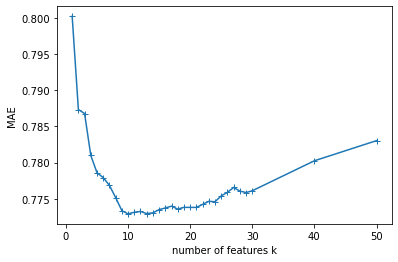

In [34]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)
for k in range_k:
    # compute the truncated SVD
    X, Y = feature_matrices(k, U, S, Vs)
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [35]:
print("MAE Naive avec Rc", np.mean(MAE))

MAE Naive avec Rc 0.7769195137752108


In [36]:
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)

Text(0, 0.5, 'MAE')

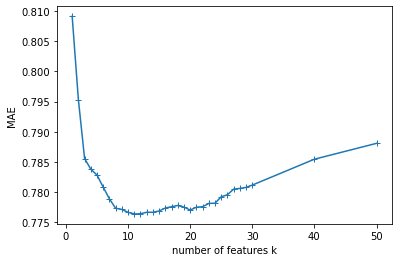

In [37]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)
for k in range_k:
    # compute the truncated SVD

    X, Y = feature_matrices(k, U, s, Vs) 
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [38]:
print("MAE Naive avec Rr", np.mean(MAE))

MAE Naive avec Rr 0.780778326330907


For U4

In [39]:
baseFileName = 'u4.base' # training dataset
testFileName = 'u4.test' # test dataset (complement of the test dataset)
userFileName = 'u.user'
itemFileName = 'u.item'

with open(baseFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(testFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    testUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['user','age','sex','occupation','zipcode'])
    User = [dict([key, value] for key, value in row.items()) for row in list(reader)] 
with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['movie', 'movie title', 'release date', 'video release date',\
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',\
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
              'Thriller', 'War', 'Western'])
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]    

In [40]:
# Fill the user-item matrix
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items
ratingPerUser = np.zeros( (nu,1) )
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']

In [41]:
Rr = np.zeros((nu,ni))
for i in range(nu):
    summ = 0
    effective = 0
    for j in range(ni):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rr[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for j in range(ni):
        if Rr[i][j]==0:
            Rr[i][j]=average
Rc = np.zeros((nu,ni))
for j in range(ni):
    summ = 0
    effective = 0
    for i in range(nu):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rc[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for i in range(nu):
        if Rc[i][j]==0:
            Rc[i][j]=average

In [42]:
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)

Text(0, 0.5, 'MAE')

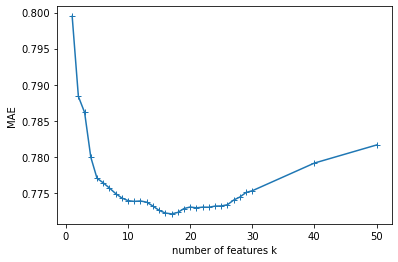

In [43]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)
for k in range_k:
    # compute the truncated SVD
    X, Y = feature_matrices(k, U, S, Vs)
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [44]:
print("MAE Naive avec Rc", np.mean(MAE))

MAE Naive avec Rc 0.7760687197481896


In [45]:
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)

Text(0, 0.5, 'MAE')

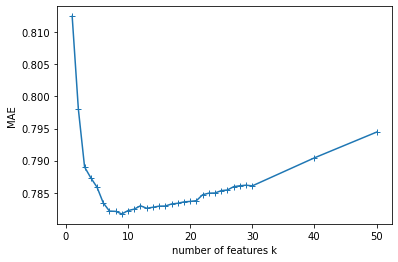

In [46]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)
for k in range_k:
    # compute the truncated SVD

    X, Y = feature_matrices(k, U, s, Vs) 
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [47]:
print("MAE Naive avec Rr", np.mean(MAE))

MAE Naive avec Rr 0.7860239990811069


For U5

In [48]:
baseFileName = 'u5.base' # training dataset
testFileName = 'u5.test' # test dataset (complement of the test dataset)
userFileName = 'u.user'
itemFileName = 'u.item'

with open(baseFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(testFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    testUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['user','age','sex','occupation','zipcode'])
    User = [dict([key, value] for key, value in row.items()) for row in list(reader)] 
with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['movie', 'movie title', 'release date', 'video release date',\
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',\
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
              'Thriller', 'War', 'Western'])
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]    

In [49]:
# Fill the user-item matrix
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items
ratingPerUser = np.zeros( (nu,1) )
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']

In [50]:
Rr = np.zeros((nu,ni))
for i in range(nu):
    summ = 0
    effective = 0
    for j in range(ni):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rr[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for j in range(ni):
        if Rr[i][j]==0:
            Rr[i][j]=average
Rc = np.zeros((nu,ni))
for j in range(ni):
    summ = 0
    effective = 0
    for i in range(nu):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rc[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for i in range(nu):
        if Rc[i][j]==0:
            Rc[i][j]=average

In [51]:
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)

Text(0, 0.5, 'MAE')

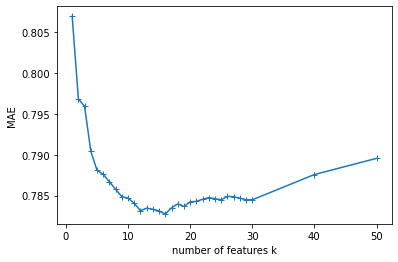

In [52]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rc, full_matrices=False)
for k in range_k:
    # compute the truncated SVD
    X, Y = feature_matrices(k, U, S, Vs)
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [53]:
print("MAE Naive avec Rc", np.mean(MAE))

MAE Naive avec Rc 0.7864461635203357


In [54]:
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)

Text(0, 0.5, 'MAE')

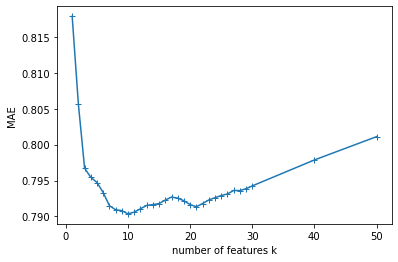

In [55]:
range_k = list(range(1,31)) + [40,50]
MAE = [] 
trueRating = [r['rating'] for r in testUserItem] # extract the true ratings 
U, s, Vs = np.linalg.svd(Rr, full_matrices=False)
for k in range_k:
    # compute the truncated SVD

    X, Y = feature_matrices(k, U, s, Vs) 
    
    # perform the prediction
    prediction = [np.dot(X[(r['user']-1),:],Y[:,(r['movie']-1)]) for r in testUserItem]
    
    # compute the errors
    errorRating = np.asmatrix(prediction) - np.asmatrix(trueRating)
    
    # Get MAE
    MAE.append(np.mean(np.abs(errorRating))) # Mean Absolute Error
pl.plot(range_k, MAE, '-+')
pl.xlabel('number of features k')
pl.ylabel('MAE')

In [56]:
print("MAE Naive avec Rr", np.mean(MAE))

MAE Naive avec Rr 0.7941787357143154


### Question 6 - Theoretical question

We have seen in class that every matrix admits a singular value decomposition. Show that a real matrix A has
a real singular value decomposition. For the proof, use the fact that the matrices $U$ and $V$ contains eigenvectors of the matrices $AA^*$ and $A^*A$ to show that they are real.

View pdf 


## Bonus - Build your own recommender system

Test the predictions on yourself: Rate a few movies among the ones present in the dataset (the list of movies is in `u.item`), maybe 10 or 20. Add theses ratings to the base dataset; you will be user `nu+1`. Generate predictions for each movie in the movie list, sort them out and produce a list of recommendation: movies you have *not rated* yet but with high predicted rating. You can also go to [movielens.org](https://movielens.org) to get recommendations on recent movies.

In [57]:
baseFileName = 'u.data_with_me' # set of data, with movies I rated
userFileName = 'u.user_with_me' # set of user, including myself
itemFileName = 'u.item'

with open(baseFileName, 'r') as f:
    fieldnames=['user','movie','rating','datestamp']
    reader = csv.DictReader(f, delimiter = '\t', fieldnames=fieldnames)
    # create a dict out of reader, converting all values to integers
    baseUserItem =  [dict([key, int(value)] for key, value in row.items()) for row in list(reader)]
    
with open(userFileName, 'r') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['user','age','sex','occupation','zipcode'])
    User = [dict([key, value] for key, value in row.items()) for row in list(reader)] 
    
with open(itemFileName, 'r', encoding='latin1') as f:
    reader = csv.DictReader(f, delimiter = '|', fieldnames=['movie', 'movie title', 'release date', 'video release date',\
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',\
              'Children''s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',\
              'Thriller', 'War', 'Western'])
    Item = [dict([key, value] for key, value in row.items()) for row in list(reader)]    

In [58]:
nu=len(User)
ni=len(Item)
        
R = np.zeros( (nu,ni) ) # nu is the total number of users, ni the total number of items
ratingPerUser = np.zeros( (nu,1) )
for row in baseUserItem:
    R[row['user']-1,row['movie']-1] = row['rating']
    
Rr = np.zeros((nu,ni))
for i in range(nu):
    summ = 0
    effective = 0
    for j in range(ni):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rr[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for j in range(ni):
        if Rr[i][j]==0:
            Rr[i][j]=average
Rc = np.zeros((nu,ni))
for j in range(ni):
    summ = 0
    effective = 0
    for i in range(nu):
        if R[i][j] > 0:
                summ = summ + R[i][j]
                effective = 1 + effective
                Rc[i][j]=R[i][j]
    if effective > 0:
        average = summ/effective
    else:
        average = 0
    for i in range(nu):
        if Rc[i][j]==0:
            Rc[i][j]=average

print(R)
print(Rr)
print(Rc)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[5.         3.         4.         ... 3.61029412 3.61029412 3.61029412]
 [4.         3.70967742 3.70967742 ... 3.70967742 3.70967742 3.70967742]
 [2.7962963  2.7962963  2.7962963  ... 2.7962963  2.7962963  2.7962963 ]
 ...
 [4.26582278 4.26582278 4.26582278 ... 4.26582278 4.26582278 4.26582278]
 [3.41071429 5.         3.41071429 ... 3.41071429 3.41071429 3.41071429]
 [3.35294118 3.35294118 3.35294118 ... 3.35294118 3.35294118 3.35294118]]
[[5.         3.         4.         ... 2.         3.         3.        ]
 [4.         3.20610687 3.03333333 ... 2.         3.         3.        ]
 [3.87831858 3.20610687 3.03333333 ... 2.         3.         3.        ]
 ...
 [3.87831858 3.20610687 3.03333333 ... 2.         3.         3.        ]
 [3.87831858 5.         3.03333333 ... 2.         3.         3.        ]
 [3.87831858 3.20610687 3.0333

In [59]:
def feature_matrices(k, U, s, Vs):
    U = U[:,:k]
    Vs = Vs[:k,:]
    s = s[:k]
    square_root_s = np.diag(s**(1/2))
    X=U.dot(square_root_s)
    Y=square_root_s.dot(Vs)
    return X, Y

In [60]:
def recommendation_list(N, nbuser, k, matrix, R):         
    U, s, Vs=np.linalg.svd(matrix, full_matrices=False)
    X, Y = feature_matrices(k, U, s, Vs)

    list_ranking_predictions=[] #the list of predicted rankings for each item corresponding to a certain user 
   
    #perform the prediction
    for i in range(0,Y.shape[1]):
        prediction = [np.dot(X[nbuser-1,:],Y[:,i]),i+1]
        list_ranking_predictions.append(prediction)
    list_ranking_predictions.sort(reverse=True) #the list of predicted rankings for each item corresponding to the user, but sorted
   
    recommendation=[] #the list of recommendations with N movies
    i=0
    while len(recommendation)<N:
        if R[nbuser-1][(list_ranking_predictions[i][1]-1)]==0:  #we check that the item have not already been rated
            recommendation.append(list_ranking_predictions[i][1])   
        i+=1 
    return recommendation


def print_recommendations(recommendation):
    nb=1
    for i in recommendation:
        for it in Item: #we try here to print the title of the movie
                if it['movie']==str(i):
                    print(str(nb)+". "+it['movie title']  )
                    nb+=1

In [61]:
#if we want a list of 20 movies for the user id corresponding to myself is 944, 
# we choose k=15, 
# and Rc because it is the matrix that was closer to reality and the best.
N=20
nbuser=944
k=15
print_recommendations(recommendation_list(N, nbuser, k, Rc, R))

1. Entertaining Angels: The Dorothy Day Story (1996)
2. Someone Else's America (1995)
3. Aiqing wansui (1994)
4. Santa with Muscles (1996)
5. Saint of Fort Washington, The (1993)
6. Star Kid (1997)
7. Marlene Dietrich: Shadow and Light (1996) 
8. Prefontaine (1997)
9. They Made Me a Criminal (1939)
10. Great Day in Harlem, A (1994)
11. Pather Panchali (1955)
12. Anna (1996)
13. Everest (1998)
14. Some Mother's Son (1996)
15. Maya Lin: A Strong Clear Vision (1994)
16. Close Shave, A (1995)
17. Wrong Trousers, The (1993)
18. Casablanca (1942)
19. Schindler's List (1993)
20. Wallace & Gromit: The Best of Aardman Animation (1996)
